In [1]:
from sys import path
path.append('..')
path.append('../../src/')

import os
import cv2
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import mlflow
import mlflow.keras
import random as rn
import tensorflow as tf
from os.path import basename, join, exists
from sys import stdout

from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout, BatchNormalization, Activation, Concatenate
from keras.layers import Conv2D, Conv2DTranspose, MaxPool2D, UpSampling2D, GlobalAvgPool2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.data_utils import Sequence
from keras.utils.vis_utils import plot_model

from skmultilearn.model_selection import iterative_train_test_split

from tensorflow.contrib.tensorboard.plugins import projector

from global_config import RANDOM_SEED, IMAGE_SIZE, FOLDER_IMAGES, FOLDER_MRKS
from local_config import FOLDER_MODELS, FILE_DATASET
from custom_losses import wing_loss
from custom_metrics import precision, recall, f1, specificity, fbeta
from custom_metrics import negative_predictive_value as npv 
from custom_metrics import matthews_correlation_coefficient as mcc
from custom_metrics import eye_localization_accuracy, eye_localization_fvc
from custom_metrics import dice_coef
from icao_dataset import ICAODataset
from data_structures import Point
from utils import plot, load

%matplotlib inline

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\util\nest.py:823: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  _pywrap_tensorflow.RegisterType("Mapping", _collections.Mapping)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\data_structures.py:312: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ListWrapper(List, collections.MutableSequence,
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\util.py:448: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ObjectIdentitySet(collections.MutableSet):
Using Te

In [2]:
PATH_TO_ROOT = '../../'

FOLDER_LOGS = join(PATH_TO_ROOT, 'logs')
FOLDER_MODELS = join(PATH_TO_ROOT, FOLDER_MODELS)
FILE_DATASET = join(PATH_TO_ROOT, FILE_DATASET)
FILE_BEST_MODEL = join(PATH_TO_ROOT, 'models/unsupervised_supervised/multilearner_2020_07_12-02_22_54.h5')

print(FOLDER_LOGS)
print(FOLDER_MODELS)
print(FILE_DATASET)
print(FILE_BEST_MODEL)

../../logs
../../models/landmark_decoder/
../../data/cropped_faces_eyes/dataset_landmark_decoder.pkl
../../models/unsupervised_supervised/multilearner_2020_07_12-02_22_54.h5


In [3]:
TEST_SIZE = 0.1
MLFLOW_EXPERIMENT_NAME = 'Landmark Decoder'

In [4]:
def timestamp_model_name(prefix='model_', suffix='', format='%Y_%m_%d-%H_%M_%S', ext='.h5'):
    from datetime import datetime
    timestamp = datetime.now().strftime(format)
    return f'{prefix}{timestamp}{suffix}{ext}'


def set_random_seeds():
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    rn.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)

# Data Loading 

In [5]:
if exists(FILE_DATASET):
    print("Dataset found. Loading...")
    dataset = pkl.load(open(FILE_DATASET, "rb"))
else:
    print("Generating dataset...")
    dataset = ICAODataset()
    dataset.load(FOLDER_IMAGES, FOLDER_MRKS, output_size=(160, 160))
    pkl.dump(dataset, open(FILE_DATASET, "wb"))

Dataset found. Loading...


In [6]:
x = np.array(dataset.images)
mrks = np.array(dataset.mrks)
y_reqs = np.array([mrk_file.photo_reqs.values() for mrk_file in mrks])
y_eyes = np.array(dataset.y_images)

print(x.shape, x.dtype)
print(y_eyes.shape, y_eyes.dtype)
print(y_reqs.shape, y_reqs.dtype)
print(len(mrks))

(4999, 160, 160, 3) float32
(4999, 160, 160, 1) uint8
(4999, 23) int32
4999


In [7]:
x /= 255
y_eyes = (y_eyes.astype(np.float32) / 255).astype(np.uint8)

In [8]:
x.min(), x.max()

(0.0, 1.0)

In [9]:
y_eyes.min(), y_eyes.max()

(0, 1)

In [10]:
np.random.seed(RANDOM_SEED)
x_train_idx, y_train_reqs, x_val_idx, y_val_reqs = iterative_train_test_split(
    np.arange(x.shape[0]).reshape(-1, 1),
    y_reqs,
    test_size=TEST_SIZE
)
x_train_idx = x_train_idx.ravel()
x_val_idx = x_val_idx.ravel()

x_train = x[x_train_idx]
x_val = x[x_val_idx]

y_train_eyes = y_eyes[x_train_idx]
y_val_eyes = y_eyes[x_val_idx]

print(x_train.shape, y_train_reqs.shape, y_train_eyes.shape)
print(x_val.shape, y_val_reqs.shape, y_val_eyes.shape)

(4490, 160, 160, 3) (4490, 23) (4490, 160, 160, 1)
(509, 160, 160, 3) (509, 23) (509, 160, 160, 1)


In [11]:
train_mrks = mrks[x_train_idx]
val_mrks = mrks[x_val_idx] 

# Model Training 

In [12]:
custom_objects = {
    "precision": precision,
    "recall": recall,
    "f1": f1,
    "specificity": specificity,
    "fbeta": fbeta,
    "negative_predictive_value": npv,
    "matthews_correlation_coefficient": mcc
}

best_model = load_model(FILE_BEST_MODEL, custom_objects=custom_objects)

for layer in best_model.layers:
    layer.trainable = False

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Instructions for updating:
Use tf.cast instead.


In [13]:
def dice_coef_loss(y_true, y_pred, smooth=1e-5):
    return 1 - dice_coef(y_true, y_pred, smooth)

In [14]:
def deconv_bn(idx, prev_input, filters, activation='relu'):
    bn_name = str(idx) + '_bn_land' 
    act_name = str(idx) + '_relu_land' 
    conv_name = str(idx) + '_conv_land' 
    
    deconv = Conv2DTranspose(filters, kernel_size=(3, 3), strides=(2, 2), padding='same', activation=None, name=conv_name)(prev_input)
    deconv = BatchNormalization(axis=-1, name=bn_name)(deconv)
    deconv = Activation(activation, name=act_name)(deconv)
    return deconv

In [15]:
mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
mlflow.log_param("test_size", TEST_SIZE)
mlflow.log_param("seed", RANDOM_SEED)
mlflow.keras.autolog()

set_random_seeds()
N_EYES = y_train_eyes.shape[1]

encoded = best_model.get_layer("encoded").output

dec_4 = deconv_bn(4, encoded, 256)
dec_3 = deconv_bn(3, dec_4, 128)
dec_2 = deconv_bn(2, dec_3, 64)
dec_1 = deconv_bn(1, dec_2, 32)
landmarks = Conv2D(filters=1, kernel_size=(3, 3), padding='same', activation='sigmoid', name='output_eyes')(dec_1)

model = Model(
    inputs=best_model.inputs,
    outputs=[
        best_model.get_layer("decoded").output,
        best_model.get_layer("outputs").output,
        landmarks
    ],
)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 160, 160, 32) 896         input[0][0]                      
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 160, 160, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
relu_1 (Activation)             (None, 160, 160, 32) 0           bn_1[0][0]                       
____________________________________________________________________________________________

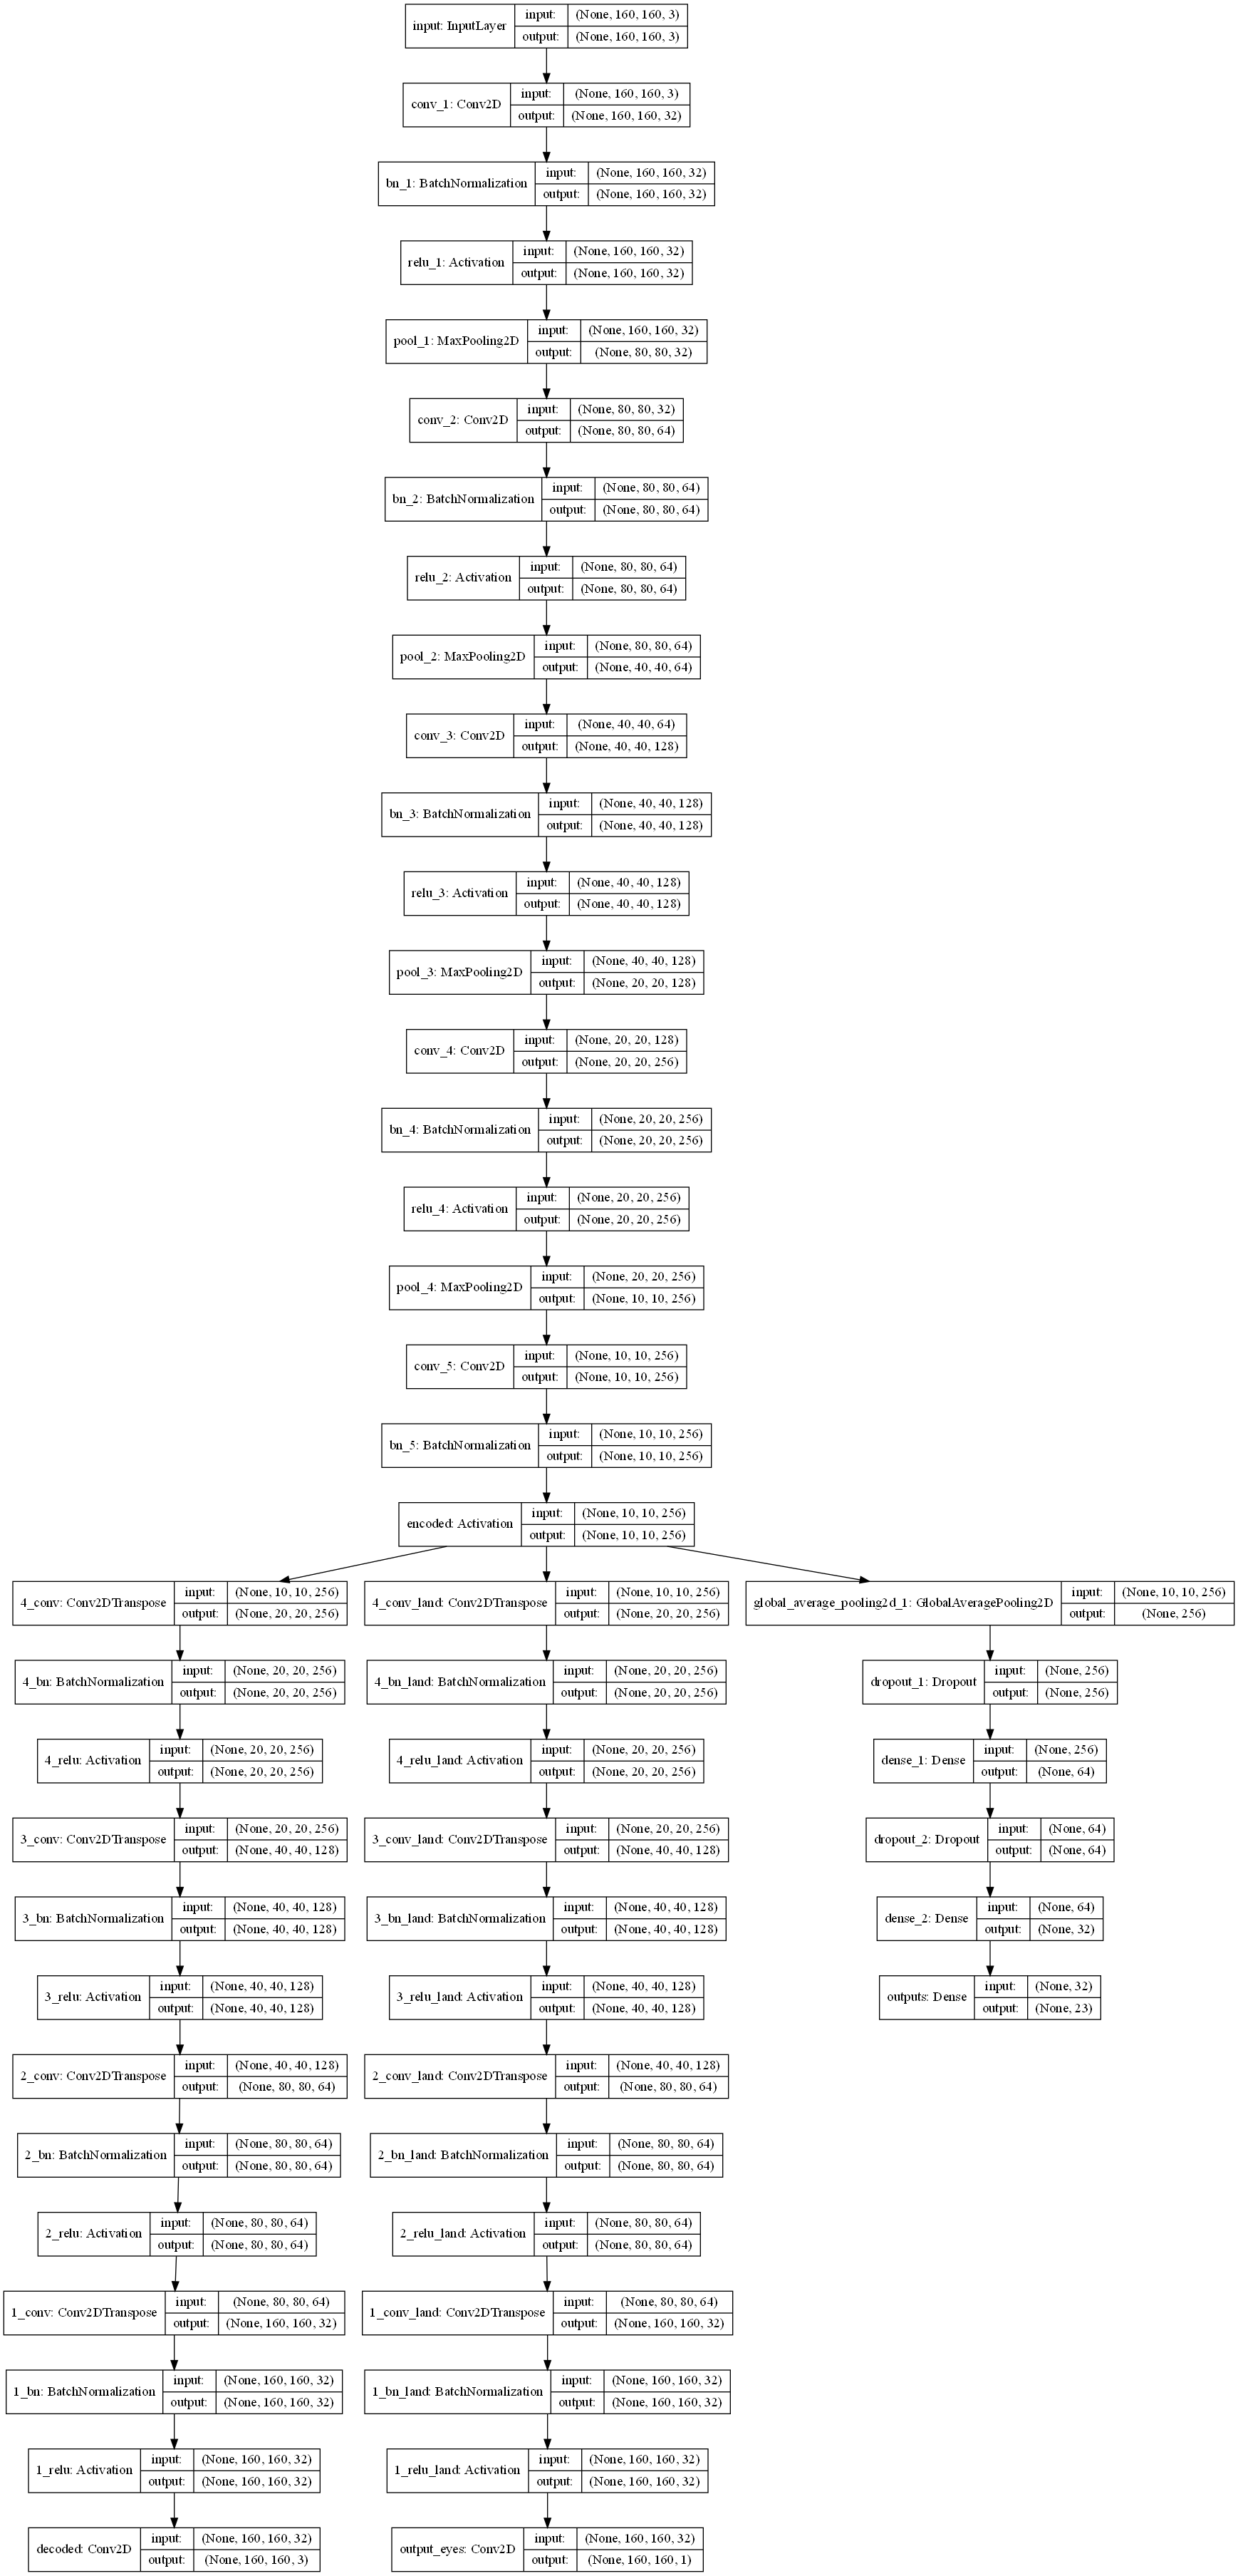

In [16]:
plot_model(model, show_shapes=True)

Train on 4490 samples, validate on 509 samples
Epoch 1/500
4490/4490 [==============================] - 54s 12ms/step - loss: 0.9427 - decoded_loss: 0.0036 - outputs_loss: 0.1679 - output_eyes_loss: 0.9425 - outputs_accuracy: 0.9317 - outputs_precision: 0.9467 - outputs_recall: 0.9717 - outputs_f1: 0.9590 - outputs_fbeta: 0.9650 - outputs_specificity: 0.7475 - outputs_negative_predictive_value: 0.8507 - outputs_matthews_correlation_coefficient: 0.7571 - output_eyes_accuracy: 0.9683 - val_loss: 0.9407 - val_decoded_loss: 0.0043 - val_outputs_loss: 0.1583 - val_output_eyes_loss: 0.9406 - val_outputs_accuracy: 0.9415 - val_outputs_precision: 0.9474 - val_outputs_recall: 0.9815 - val_outputs_f1: 0.9639 - val_outputs_fbeta: 0.9737 - val_outputs_specificity: 0.7720 - val_outputs_negative_predictive_value: 0.9027 - val_outputs_matthews_correlation_coefficient: 0.7997 - val_output_eyes_accuracy: 0.9999

Epoch 00001: val_output_eyes_loss improved from inf to 0.94057, saving model to ../../model

4490/4490 [==============================] - 48s 11ms/step - loss: 0.7503 - decoded_loss: 0.0036 - outputs_loss: 0.1681 - output_eyes_loss: 0.7507 - outputs_accuracy: 0.9315 - outputs_precision: 0.9462 - outputs_recall: 0.9718 - outputs_f1: 0.9588 - outputs_fbeta: 0.9650 - outputs_specificity: 0.7448 - outputs_negative_predictive_value: 0.8501 - outputs_matthews_correlation_coefficient: 0.7551 - output_eyes_accuracy: 0.9999 - val_loss: 0.8066 - val_decoded_loss: 0.0043 - val_outputs_loss: 0.1583 - val_output_eyes_loss: 0.8063 - val_outputs_accuracy: 0.9415 - val_outputs_precision: 0.9474 - val_outputs_recall: 0.9815 - val_outputs_f1: 0.9639 - val_outputs_fbeta: 0.9737 - val_outputs_specificity: 0.7720 - val_outputs_negative_predictive_value: 0.9027 - val_outputs_matthews_correlation_coefficient: 0.7997 - val_output_eyes_accuracy: 0.9999

Epoch 00009: val_output_eyes_loss improved from 0.82183 to 0.80634, saving model to ../../models/landmark_decoder/landmark_decoder_2022_10_01-12_07_03

4490/4490 [==============================] - 49s 11ms/step - loss: 0.6778 - decoded_loss: 0.0036 - outputs_loss: 0.1677 - output_eyes_loss: 0.6777 - outputs_accuracy: 0.9314 - outputs_precision: 0.9464 - outputs_recall: 0.9716 - outputs_f1: 0.9588 - outputs_fbeta: 0.9649 - outputs_specificity: 0.7452 - outputs_negative_predictive_value: 0.8484 - outputs_matthews_correlation_coefficient: 0.7546 - output_eyes_accuracy: 0.9999 - val_loss: 0.7765 - val_decoded_loss: 0.0043 - val_outputs_loss: 0.1583 - val_output_eyes_loss: 0.7763 - val_outputs_accuracy: 0.9415 - val_outputs_precision: 0.9474 - val_outputs_recall: 0.9815 - val_outputs_f1: 0.9639 - val_outputs_fbeta: 0.9737 - val_outputs_specificity: 0.7720 - val_outputs_negative_predictive_value: 0.9027 - val_outputs_matthews_correlation_coefficient: 0.7997 - val_output_eyes_accuracy: 0.9999

Epoch 00017: val_output_eyes_loss improved from 0.77730 to 0.77625, saving model to ../../models/landmark_decoder/landmark_decoder_2022_10_01-12_07_03


Epoch 00025: val_output_eyes_loss did not improve from 0.77462
Epoch 26/500
4490/4490 [==============================] - 48s 11ms/step - loss: 0.6227 - decoded_loss: 0.0035 - outputs_loss: 0.1673 - output_eyes_loss: 0.6228 - outputs_accuracy: 0.9316 - outputs_precision: 0.9468 - outputs_recall: 0.9716 - outputs_f1: 0.9590 - outputs_fbeta: 0.9649 - outputs_specificity: 0.7481 - outputs_negative_predictive_value: 0.8498 - outputs_matthews_correlation_coefficient: 0.7569 - output_eyes_accuracy: 0.9999 - val_loss: 0.8006 - val_decoded_loss: 0.0043 - val_outputs_loss: 0.1583 - val_output_eyes_loss: 0.8005 - val_outputs_accuracy: 0.9415 - val_outputs_precision: 0.9474 - val_outputs_recall: 0.9815 - val_outputs_f1: 0.9639 - val_outputs_fbeta: 0.9737 - val_outputs_specificity: 0.7720 - val_outputs_negative_predictive_value: 0.9027 - val_outputs_matthews_correlation_coefficient: 0.7997 - val_output_eyes_accuracy: 0.9999

Epoch 00026: val_output_eyes_loss did not improve from 0.77462
Epoch 27/5


Epoch 00034: val_output_eyes_loss did not improve from 0.76544
Epoch 35/500
4490/4490 [==============================] - 46s 10ms/step - loss: 0.5675 - decoded_loss: 0.0036 - outputs_loss: 0.1671 - output_eyes_loss: 0.5687 - outputs_accuracy: 0.9323 - outputs_precision: 0.9473 - outputs_recall: 0.9717 - outputs_f1: 0.9593 - outputs_fbeta: 0.9653 - outputs_specificity: 0.7508 - outputs_negative_predictive_value: 0.8505 - outputs_matthews_correlation_coefficient: 0.7590 - output_eyes_accuracy: 0.9999 - val_loss: 0.7779 - val_decoded_loss: 0.0043 - val_outputs_loss: 0.1583 - val_output_eyes_loss: 0.7774 - val_outputs_accuracy: 0.9415 - val_outputs_precision: 0.9474 - val_outputs_recall: 0.9815 - val_outputs_f1: 0.9639 - val_outputs_fbeta: 0.9737 - val_outputs_specificity: 0.7720 - val_outputs_negative_predictive_value: 0.9027 - val_outputs_matthews_correlation_coefficient: 0.7997 - val_output_eyes_accuracy: 0.9999

Epoch 00035: val_output_eyes_loss did not improve from 0.76544
Epoch 36/5


Epoch 00043: val_output_eyes_loss did not improve from 0.76544
Epoch 44/500
4490/4490 [==============================] - 46s 10ms/step - loss: 0.5225 - decoded_loss: 0.0035 - outputs_loss: 0.1659 - output_eyes_loss: 0.5217 - outputs_accuracy: 0.9322 - outputs_precision: 0.9468 - outputs_recall: 0.9721 - outputs_f1: 0.9592 - outputs_fbeta: 0.9655 - outputs_specificity: 0.7477 - outputs_negative_predictive_value: 0.8518 - outputs_matthews_correlation_coefficient: 0.7578 - output_eyes_accuracy: 0.9999 - val_loss: 0.7862 - val_decoded_loss: 0.0043 - val_outputs_loss: 0.1583 - val_output_eyes_loss: 0.7859 - val_outputs_accuracy: 0.9415 - val_outputs_precision: 0.9474 - val_outputs_recall: 0.9815 - val_outputs_f1: 0.9639 - val_outputs_fbeta: 0.9737 - val_outputs_specificity: 0.7720 - val_outputs_negative_predictive_value: 0.9027 - val_outputs_matthews_correlation_coefficient: 0.7997 - val_output_eyes_accuracy: 0.9999

Epoch 00044: val_output_eyes_loss did not improve from 0.76544
Epoch 45/5


Epoch 00052: val_output_eyes_loss did not improve from 0.76544
Epoch 53/500
4490/4490 [==============================] - 47s 11ms/step - loss: 0.4834 - decoded_loss: 0.0035 - outputs_loss: 0.1664 - output_eyes_loss: 0.4835 - outputs_accuracy: 0.9326 - outputs_precision: 0.9474 - outputs_recall: 0.9721 - outputs_f1: 0.9596 - outputs_fbeta: 0.9656 - outputs_specificity: 0.7499 - outputs_negative_predictive_value: 0.8526 - outputs_matthews_correlation_coefficient: 0.7598 - output_eyes_accuracy: 0.9999 - val_loss: 0.8070 - val_decoded_loss: 0.0043 - val_outputs_loss: 0.1583 - val_output_eyes_loss: 0.8070 - val_outputs_accuracy: 0.9415 - val_outputs_precision: 0.9474 - val_outputs_recall: 0.9815 - val_outputs_f1: 0.9639 - val_outputs_fbeta: 0.9737 - val_outputs_specificity: 0.7720 - val_outputs_negative_predictive_value: 0.9027 - val_outputs_matthews_correlation_coefficient: 0.7997 - val_output_eyes_accuracy: 0.9999

Epoch 00053: val_output_eyes_loss did not improve from 0.76544
Epoch 54/5


Epoch 00061: val_output_eyes_loss did not improve from 0.76544
Epoch 62/500
4490/4490 [==============================] - 46s 10ms/step - loss: 0.4432 - decoded_loss: 0.0037 - outputs_loss: 0.1679 - output_eyes_loss: 0.4436 - outputs_accuracy: 0.9315 - outputs_precision: 0.9459 - outputs_recall: 0.9722 - outputs_f1: 0.9588 - outputs_fbeta: 0.9652 - outputs_specificity: 0.7432 - outputs_negative_predictive_value: 0.8518 - outputs_matthews_correlation_coefficient: 0.7552 - output_eyes_accuracy: 0.9999 - val_loss: 0.7801 - val_decoded_loss: 0.0043 - val_outputs_loss: 0.1583 - val_output_eyes_loss: 0.7801 - val_outputs_accuracy: 0.9415 - val_outputs_precision: 0.9474 - val_outputs_recall: 0.9815 - val_outputs_f1: 0.9639 - val_outputs_fbeta: 0.9737 - val_outputs_specificity: 0.7720 - val_outputs_negative_predictive_value: 0.9027 - val_outputs_matthews_correlation_coefficient: 0.7997 - val_output_eyes_accuracy: 0.9999

Epoch 00062: val_output_eyes_loss did not improve from 0.76544
Epoch 63/5


Epoch 00070: val_output_eyes_loss did not improve from 0.76544
Epoch 71/500
4490/4490 [==============================] - 46s 10ms/step - loss: 0.4264 - decoded_loss: 0.0036 - outputs_loss: 0.1683 - output_eyes_loss: 0.4262 - outputs_accuracy: 0.9308 - outputs_precision: 0.9461 - outputs_recall: 0.9712 - outputs_f1: 0.9584 - outputs_fbeta: 0.9645 - outputs_specificity: 0.7439 - outputs_negative_predictive_value: 0.8472 - outputs_matthews_correlation_coefficient: 0.7528 - output_eyes_accuracy: 0.9999 - val_loss: 0.7763 - val_decoded_loss: 0.0043 - val_outputs_loss: 0.1583 - val_output_eyes_loss: 0.7758 - val_outputs_accuracy: 0.9415 - val_outputs_precision: 0.9474 - val_outputs_recall: 0.9815 - val_outputs_f1: 0.9639 - val_outputs_fbeta: 0.9737 - val_outputs_specificity: 0.7720 - val_outputs_negative_predictive_value: 0.9027 - val_outputs_matthews_correlation_coefficient: 0.7997 - val_output_eyes_accuracy: 0.9999

Epoch 00071: val_output_eyes_loss did not improve from 0.76544
Epoch 72/5


Epoch 00079: val_output_eyes_loss did not improve from 0.76544
Restoring model weights from the end of the best epoch
Epoch 00079: early stopping


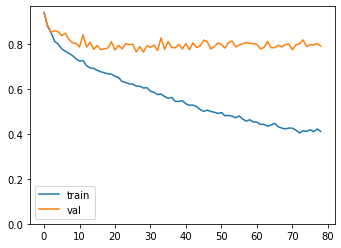

In [17]:
DECODED_LOSS_WEIGHT = 0.0
REQS_LOSS_WEIGHT = 0.0
EYES_LOSS_WEIGHT = 1.0

mlflow.log_param("decoded loss weight", DECODED_LOSS_WEIGHT)
mlflow.log_param("reqs loss weight", REQS_LOSS_WEIGHT)
mlflow.log_param("eyes loss weight", EYES_LOSS_WEIGHT)

losses = {
    "decoded": "mean_squared_error",
    "outputs": "binary_crossentropy",
    "output_eyes": dice_coef_loss,
}

loss_weights = {
    "decoded": DECODED_LOSS_WEIGHT,
    "outputs": REQS_LOSS_WEIGHT,
    "output_eyes": EYES_LOSS_WEIGHT,
}

metrics = {
    "outputs": ["accuracy", precision, recall, f1, fbeta, specificity, npv, mcc],
    "output_eyes": ["accuracy"]
}
METRIC_TO_MONITOR = "val_output_eyes_loss"
METRIC_MODE = "min"

model.compile(optimizer='adam', loss=losses, loss_weights=loss_weights, metrics=metrics)

FILE_MODEL = FOLDER_MODELS + timestamp_model_name(prefix="landmark_decoder_")
list_callbacks = [
    ModelCheckpoint(FILE_MODEL, monitor=METRIC_TO_MONITOR, mode=METRIC_MODE, verbose=1, save_best_only=True), 
    EarlyStopping(monitor=METRIC_TO_MONITOR, mode=METRIC_MODE, patience=50, verbose=1, restore_best_weights=True)
]

outputs_train = {
    "decoded": x_train,
    "outputs": y_train_reqs,
    "output_eyes": y_train_eyes,
}

outputs_valid = {
    "decoded": x_val,
    "outputs": y_val_reqs,
    "output_eyes": y_val_eyes,
}

hist = model.fit(
    x=x_train,
    y=outputs_train,
    batch_size=32,
    epochs=500,
    validation_data=(x_val, outputs_valid),
    callbacks=list_callbacks,
)

plot.keras_hist(hist.history)

# Test Model

In [170]:
def argmax_2d(x, k=1):
    top_indices = np.argsort(x.flatten())[:-k-1:-1]
    return np.stack(((top_indices // x.shape[1]), (top_indices % x.shape[1])), -1)

def get_eyes_landmarks(y_pred):
    im_width = y_pred.shape[1]
    y_right = argmax_2d(y_pred[:, :(im_width // 2)])
    y_left = argmax_2d(y_pred[:, (im_width // 2):]) + [0, im_width // 2]
    return y_right, y_left

[1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1]
[[1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1]]
[[77 65]] [[79 94]]
[[154  28]] [[133  93]]
[0 1 1 1 1 1 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1]
[[0 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1]]
[[72 69]] [[72 93]]
[[72 69]] [[72 93]]
[1 0 1 1 1 1 1 0 0 1 1 1 0 1 1 1 0 1 0 1 1 0 1]
[[1 0 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 0 1 1 0 1]]
[[72 69]] [[72 90]]
[[88 70]] [[ 20 138]]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1]]
[[73 66]] [[72 91]]
[[74 66]] [[72 92]]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]
[[75 67]] [[75 91]]
[[75 67]] [[74 91]]
[1 0 1 1 1 1 1 1 0 0 1 1 0 1 1 1 0 1 1 1 1 0 1]
[[1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1]]
[[76 69]] [[76 87]]
[[133  13]] [[19 93]]
[1 0 1 0 1 1 1 0 0 0 1 1 0 1 1 1 1 1 0 1 1 0 1]
[[1 0 1 1 1 1 1 0 0 0 1 1 0 1 1 1 1 1 0 1 1 0 1]]
[[71 70]] [[70 89]]
[[70 71]] [[71 89]]
[0 1 1 1 1 1 1 1 1 0 1 1 0

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


[1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 1]
[[1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1]]
[[78 68]] [[76 96]]
[[140   3]] [[154  88]]
[1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1]
[[1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1]]
[[72 66]] [[71 94]]
[[71 68]] [[71 93]]
[1 0 1 0 1 1 1 0 0 0 1 1 0 1 1 1 1 1 0 1 1 0 1]
[[1 0 1 1 1 1 1 0 0 0 1 1 0 1 1 1 1 1 0 1 1 0 1]]
[[71 70]] [[70 89]]
[[70 71]] [[71 89]]
[1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]
[[76 69]] [[75 93]]
[[76 68]] [[74 94]]
[1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1]
[[1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1]]
[[80 69]] [[79 94]]
[[77 68]] [[133 109]]
[1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 0 1]
[[1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 0 1]]
[[76 67]] [[75 95]]
[[138   0]] [[117 140]]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1]
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1]]
[[68 68]] [[70 91]]
[[69 68]] [[69 92]]
[0 1 1 0 1 1 1 1 1 0 1 1

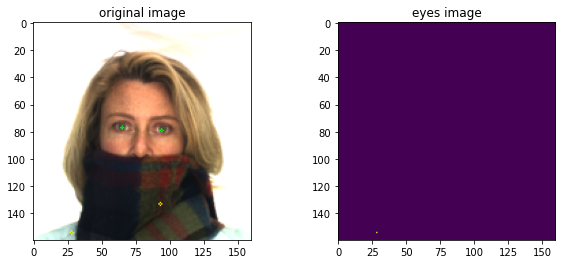

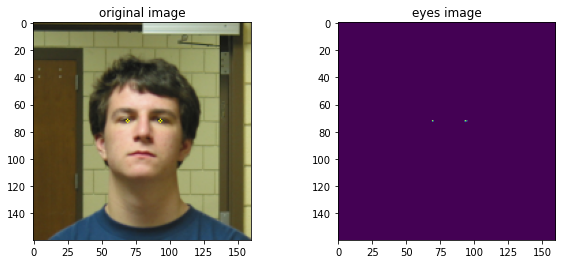

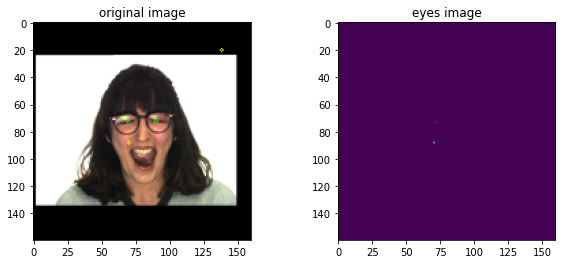

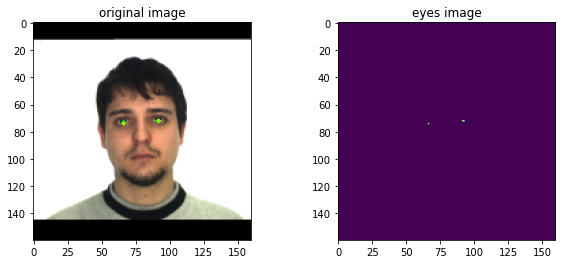

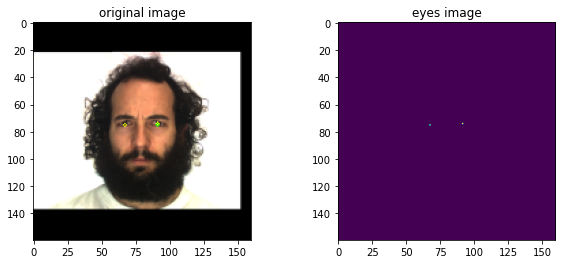

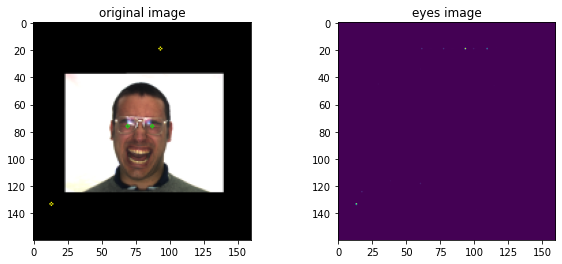

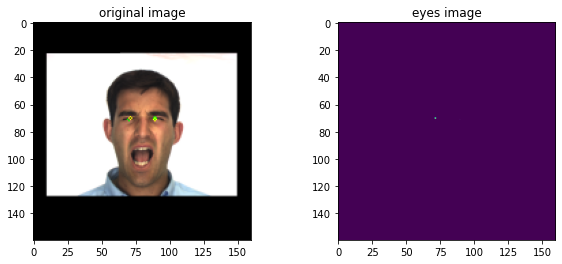

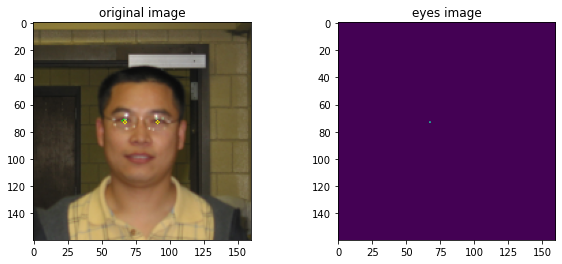

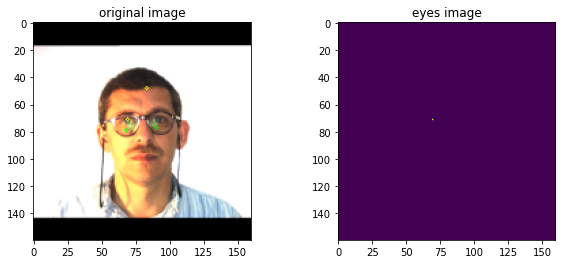

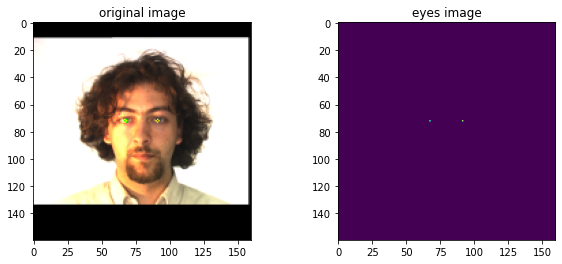

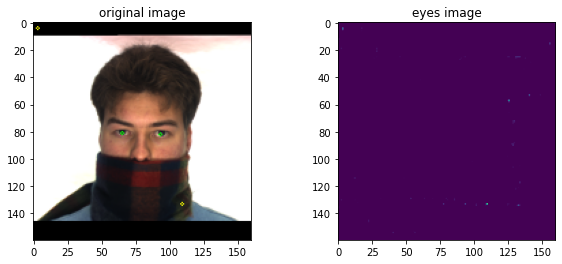

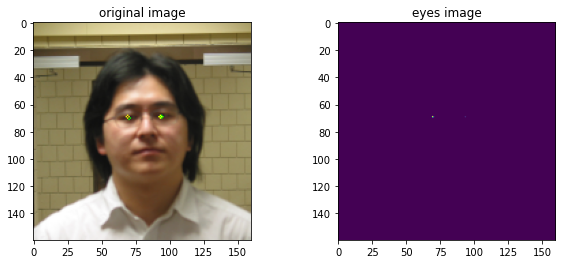

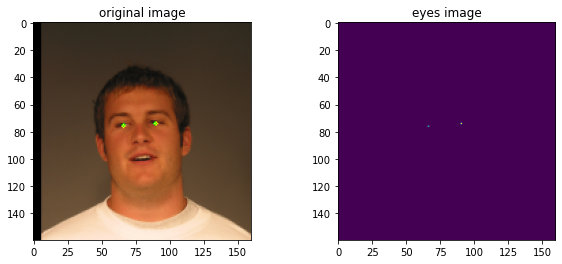

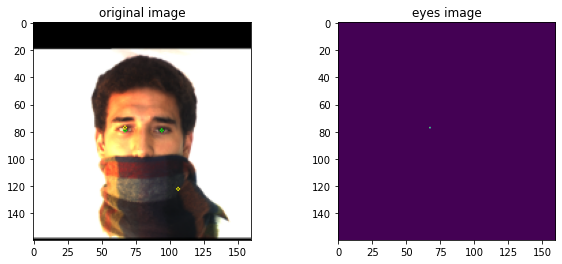

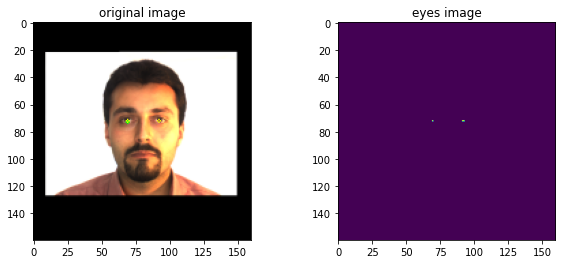

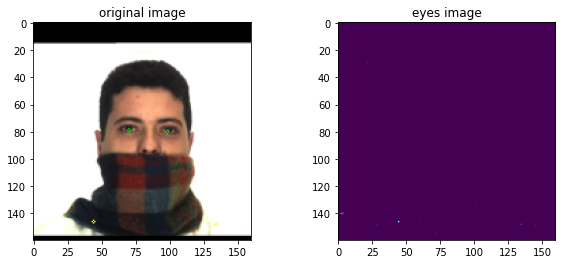

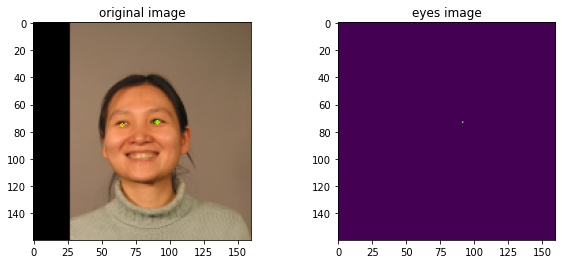

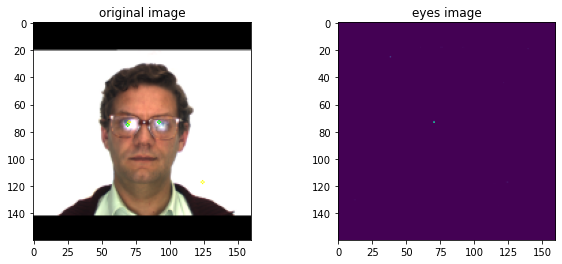

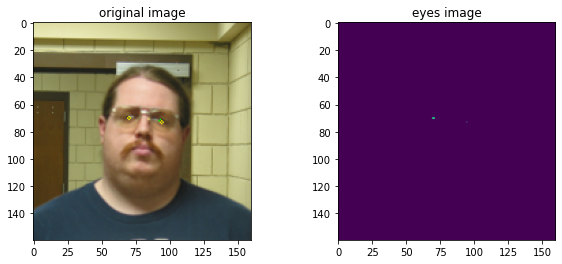

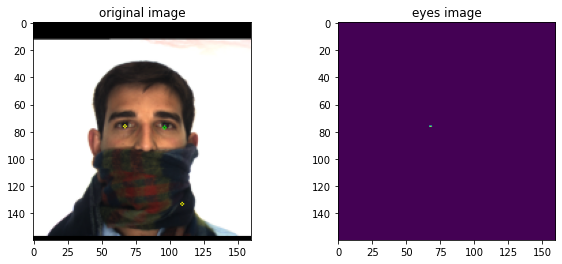

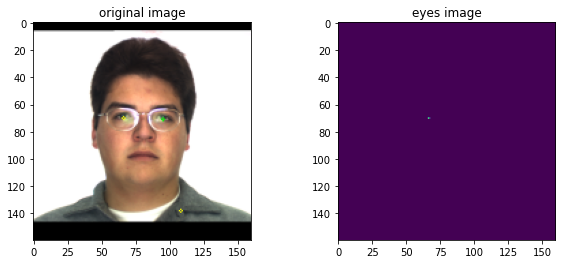

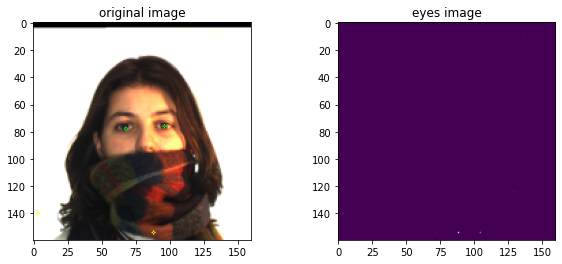

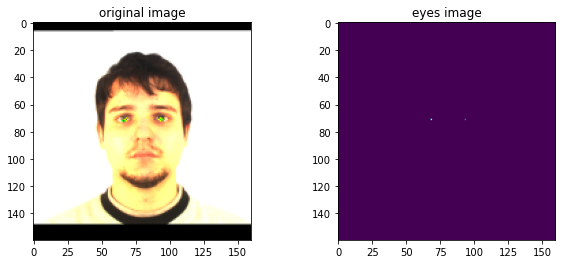

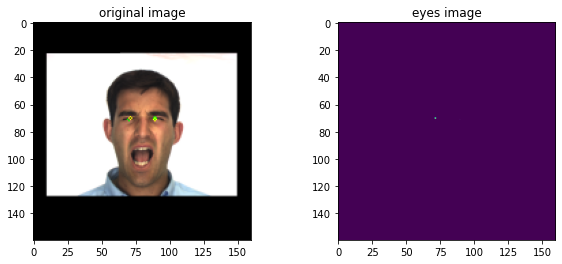

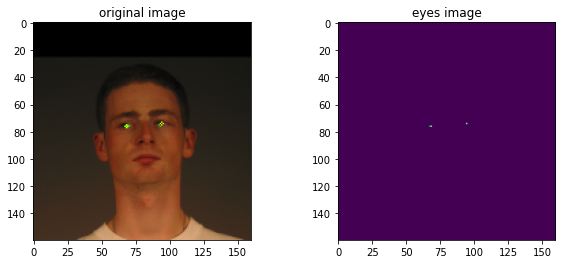

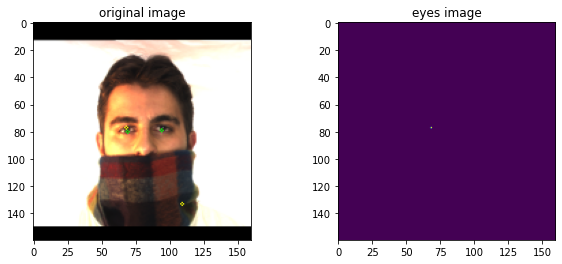

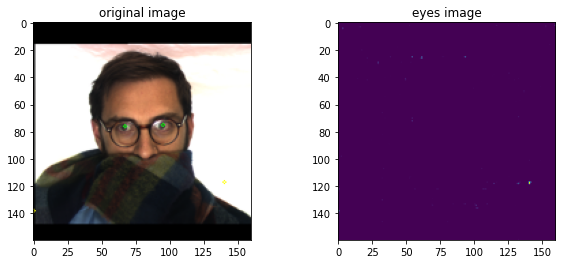

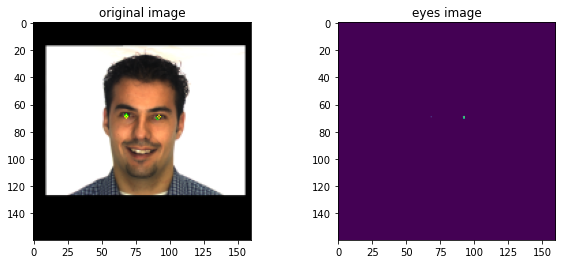

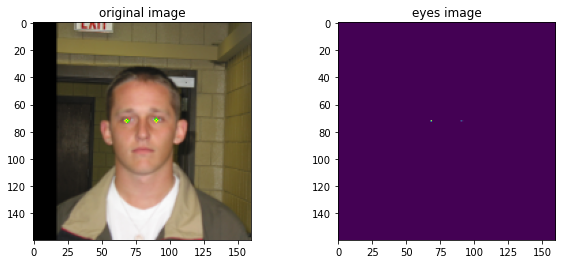

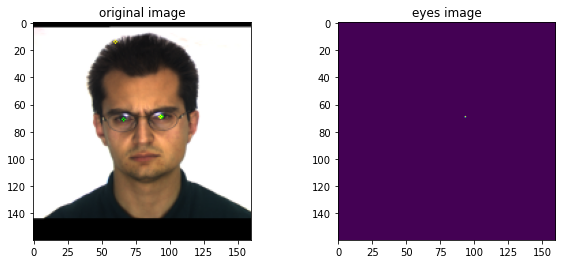

In [224]:
for i in range(30):
    random_idx = np.random.choice(x_val.shape[0])
    im = np.expand_dims(x_val[random_idx], axis=0)
    y_true_reqs = y_val_reqs[random_idx]
    y_true_eyes = y_val_eyes[random_idx]
    y_pred_decoded, y_pred_reqs, y_pred_eyes = model.predict(im)
    y_pred_reqs = np.where(y_pred_reqs > 0.5, 1, 0)

    print(y_true_reqs, y_pred_reqs, sep='\n')

    im = (im * 255).squeeze()[:, :, ::-1].astype(np.uint8)
    true_r, true_l = get_eyes_landmarks(y_true_eyes.squeeze())
    pred_r, pred_l = get_eyes_landmarks(y_pred_eyes.squeeze())
    cv2.circle(im, tuple(true_r[0][::-1]), radius=1, color=(0, 255, 0))
    cv2.circle(im, tuple(true_l[0][::-1]), radius=1, color=(0, 255, 0))
    cv2.circle(im, tuple(pred_r[0][::-1]), radius=1, color=(255, 255, 0))
    cv2.circle(im, tuple(pred_l[0][::-1]), radius=1, color=(255, 255, 0))

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(im.squeeze())
    plt.title('original image')

    plt.subplot(1, 2, 2)
    plt.imshow(y_pred_eyes.squeeze())
    plt.title('eyes image')
    fig_name = 
    plt.savefig(f"results/{true}.png")